In [99]:


import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import StandardScaler # For standardizing the data
from sklearn.cluster import KMeans
from collections import Counter
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA 
import ace_tools_open as tools
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import pandas as pd




In [100]:
# 1. Load the data from the Excel spreadsheet:
cellcycle_path = 'C:/Users/semel/Downloads/compbio/Cell-Cycle-Set.xlsx'
df = pd.read_excel(cellcycle_path)

# 2. Tidy up the data, drop rows with missing NaN values:
df = df.dropna()




In [101]:
# 1. Calculate the variance and mean of the protein and mRNA concentrations:
meanvar = []
for column in ['mean_RNA_G1', 'mean_RNA_S', 'mean_RNA_G2', 'mean_protein_G1', 'mean_protein_S', 'mean_protein_G2']:
    variance = df[column].var()
    mean = df[column].mean()

    meanvar.append({'Cell Cycle Phase': column, 'Mean': mean, 'Variance': variance})

# 2. Convert list to DataFrame for better readability: 
meanvar_df = pd.DataFrame(meanvar)

# 3. Print the results:
tools.display_dataframe_to_user(name = 'Table 1', dataframe = meanvar_df)





Table 1


# Mean and Variance Analysis:


+ Table 1 shows that mRNA concentration remains relatively stable across G1, S, and G2 phases, with similar mean values (≈ 11.22) and low variance
(≈2.14). 
+ On the contrary, protein concentration is higher overall (mean ≈ 24.59) but more variable (variance ≈10.29), suggesting that RNA levels alone do not
fully predict protein levels. 
+ Additionally, protein levels are lower in the S phase (mean = 22.85) compared to phases G1 and G2, possibly indicating increased protein utilization for duplicating the chromosomes during synthesis.


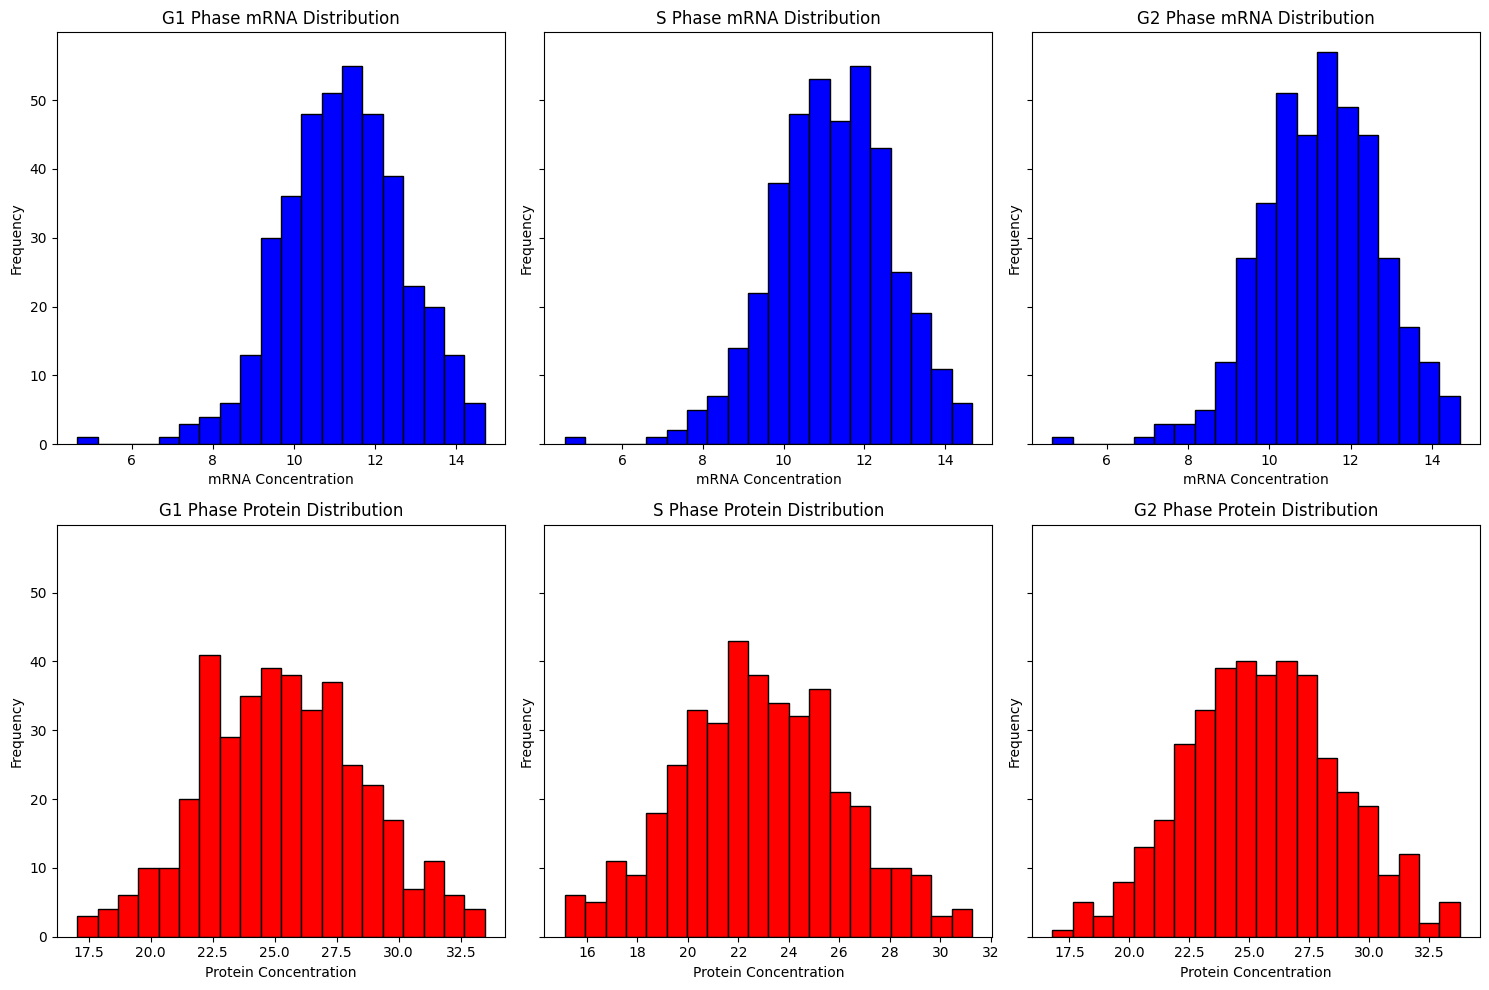

In [102]:
# 1. Generate a histogram of the cell cycle stages of the RNA and protein distribution:

# 2. Create a figure and axis for the plot:
fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharey=True)

# 3. Define the cell cycle phases and the corresponding columns: 
phases = ['G1', 'S', 'G2']
mRNA_columns = ['mean_RNA_G1', 'mean_RNA_S', 'mean_RNA_G2']
protein_columns = ['mean_protein_G1', 'mean_protein_S', 'mean_protein_G2']

# 4. Plot the histograms for RNA and protein concentrations in each phase:
for i, phase in enumerate(phases):
    axes[0, i].hist(df[mRNA_columns[i]], bins=20, color='blue', edgecolor='black')
    axes[0, i].set_title(f'{phase} Phase mRNA Distribution')
    axes[0, i].set_xlabel('mRNA Concentration')
    axes[0, i].set_ylabel('Frequency')

    axes[1, i].hist(df[protein_columns[i]], bins=20, color='red', edgecolor='black')
    axes[1, i].set_title(f'{phase} Phase Protein Distribution')
    axes[1, i].set_xlabel('Protein Concentration')
    axes[1, i].set_ylabel('Frequency')

# 5. Display the results:
plt.tight_layout()
plt.show()




# Histogram Analysis: 

+ The histogram for phase G1 shows mRNA concentration being tightly distributed around a lower mean (≈11.22) with low variance. 
+ Protein concentration is significantly higher (≈25.35) and more variable. In addition, the histogram for phase S shows stable RNA levels, with a similar mean (≈11.19) and variance compared to G1.
+ However, protein concentration decreases slightly (≈22.85), suggesting increased protein utilization, possibly for chromosome duplication.
+ Lastly, the histogram for phase G2, shows consistent RNA levels (≈11.26), while protein concentration increases again (≈25.57), aligning with cell cycle
progression and preparation for mitosis. 



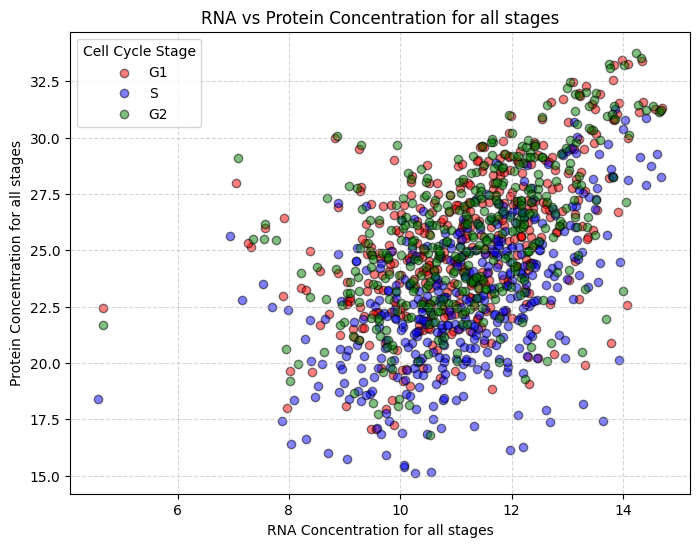

In [103]:
# 1. Generate a scatterplot of the RNA vs Protein concentrations for each stage of the cell cycle:
plt.figure (figsize=(8, 6))

# a. G1 phase:
plt.scatter(df['mean_RNA_G1'], df['mean_protein_G1'], label='G1', color='red', alpha = 0.5, edgecolors='black')
# b. S phase:
plt.scatter(df['mean_RNA_S'], df['mean_protein_S'], label='S', color='blue', alpha = 0.5, edgecolors='black')
# c. G2 phase:
plt.scatter(df['mean_RNA_G2'], df['mean_protein_G2'], label='G2', color='green', alpha = 0.5, edgecolors='black')

plt.xlabel('RNA Concentration for all stages')
plt.ylabel('Protein Concentration for all stages')
plt.title('RNA vs Protein Concentration for all stages')
plt.legend(title = 'Cell Cycle Stage', loc = 'upper left')
plt.grid (True, linestyle = '--', alpha = 0.5)

plt.show()


# Observations - State what you notice about these, and how this might affect inferring Protein from mRNA concentrations: 

+ All things considered, RNA cannot be used as the sole predictor for protein expression, as our analysis
reveals that protein levels vary more widely than RNA levels, suggesting the influence of transactional, post-transactional, translational and post-translational
mechanisms.
+ This aligns with broader findings in systems biology.
+ Thus, direct inference of protein expression from RNA concentrations alone is both challenging and potentially misleading.

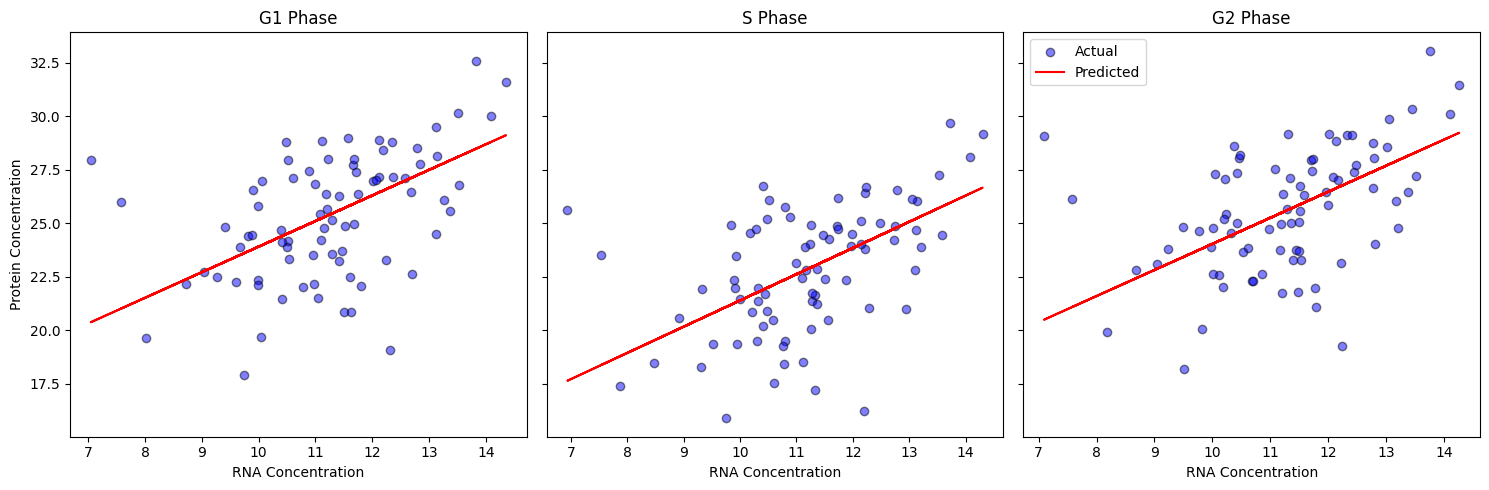

Table 2


In [104]:
# 1. Define the cell cycle phases and the corresponding columns:
phases = ['G1', 'S', 'G2']
mRNA_columns = ['mean_RNA_G1', 'mean_RNA_S', 'mean_RNA_G2']
protein_columns = ['mean_protein_G1', 'mean_protein_S', 'mean_protein_G2']

# 2. Create a figure and axis for the plot:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# 3. Fit a linear regression model for each phase:
results_linearreg = []

for i, phase in enumerate(phases):
    X_train, X_test, y_train, y_test = train_test_split(df[mRNA_columns[i]].values.reshape(-1, 1), df[protein_columns[i]], test_size=0.2, random_state=0)
    model = LinearRegression()
    model.fit(X_train, y_train)

    # 4. Make the predictions:
    y_pred = model.predict(X_test)

    # 5. Plot the data points and the regression line:
    axes[i].scatter(X_test, y_test, color='blue', label='Actual', alpha=0.5, edgecolors='black')
    axes[i].plot(X_test, y_pred, color='red', label='Predicted')
    axes[i].set_title(f'{phase} Phase')
    axes[i].set_xlabel('RNA Concentration')

    # 6. Calculate the R^2 score:
    r2 = model.score(X_test, y_test)

    # 7. Calculate MSE:
    mse = np.mean((y_pred - y_test) ** 2)

    # 8. All results are for analysis and visualization purposes:
    results_linearreg.append({
        'Phase': phase,
        'Intercept': model.intercept_,
        'Coefficient': model.coef_[0],
        'R²': r2,
        'MSE': mse
    })

# 9. Display the results:
axes[0].set_ylabel('Protein Concentration')
plt.legend()
plt.tight_layout()
plt.show()

# 10. Convert the results to a DataFrame for better readability:
linear_df = pd.DataFrame(results_linearreg)

# 11. Print the results:
tools.display_dataframe_to_user(name = 'Table 2', dataframe = linear_df)








# Linear Model Performance Analysis: 


+ After fitting linear models for each cell cycle phase, we assessed the model performance using Mean Squared Error (MSE) and the coefficient of determination (R^2).
+ The MSE values reveal that G2 has the lowest MSE (6.749), indicating slightly better predictive performance compared to G1 (6.861) and S (6.867).
+ The R2 values are relatively low across all phases, with G1 and G2 showing weak positive correlations (0.201 and 0.188, respectively), and S-phase presenting a
slightly higher R2 of 0.217.
+ This suggests that RNA levels offer inadequate predictive power for protein concentrations across all phases.
+ The refined analysis, reaffirms that RNA levels alone are insufficient for accurately predicting protein concentrations. 
+ The S-phase, despite having a higher correlation, shows no significant improvement in predictive accuracy, hinting at complex regulatory mechanisms taking place during said phase.


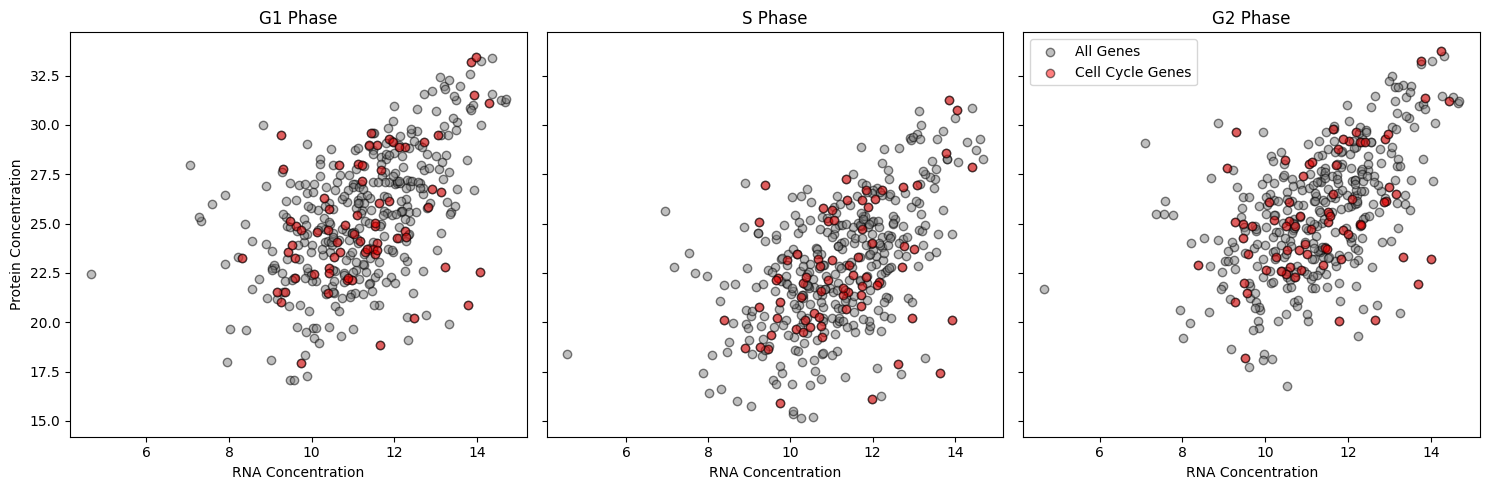

In [105]:
# 1. Find all genes that contain cell cycle in their GOBP term: 
cell_cycle_genes = df[df['GOBP'].str.contains('cell cycle', case=False)]['Gene_Name']
phases = ['G1', 'S', 'G2']
mRNA_columns = ['mean_RNA_G1', 'mean_RNA_S', 'mean_RNA_G2']
protein_columns = ['mean_protein_G1', 'mean_protein_S', 'mean_protein_G2']


# 2. Plot them as a scatter-plot overlaid across all genes for each stage of the cell cycle:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for i, phase in enumerate(phases):
    axes[i].scatter(df[mRNA_columns[i]], df[protein_columns[i]], label='All Genes', color='gray', alpha=0.5, edgecolors='black')
    axes[i].scatter(df[mRNA_columns[i]][df['Gene_Name'].isin(cell_cycle_genes)], df[protein_columns[i]][df['Gene_Name'].isin(cell_cycle_genes)], label='Cell Cycle Genes', color='red', alpha=0.5, edgecolors='black')
    axes[i].set_title(f'{phase} Phase')
    axes[i].set_xlabel('RNA Concentration')

axes[0].set_ylabel('Protein Concentration')
plt.legend()
plt.tight_layout()
plt.show()








In [106]:
# 1. Calculate correlations between RNA and protein concentrations for cell cycle genes in each stage of the cell cycle and print them:
correlations = {}
correlations_results = []
for stage in ['G1', 'S', 'G2']:
    correlations[stage] = df[df['Gene_Name'].isin(cell_cycle_genes)][f'mean_RNA_{stage}'].corr(df[df['Gene_Name'].isin(cell_cycle_genes)][f'mean_protein_{stage}'])
    correlations_results.append({'Stage': stage, 'Correlation': correlations[stage]})
correlations_df = pd.DataFrame(correlations_results)

# 2. Print the results:
tools.display_dataframe_to_user(name = 'Table 3', dataframe = correlations_df)



Table 3


# Comparing All Genes vs. Cell Cycle Genes:


+ After separating cell cycle genes from all other genes in the dataset, the computed correlation values suggest a moderate positive correlation between RNA and protein concentrations for cell cycle genes.
+ The correlation values still remain weaker than expected for a strong RNA-protein predictive relationship.

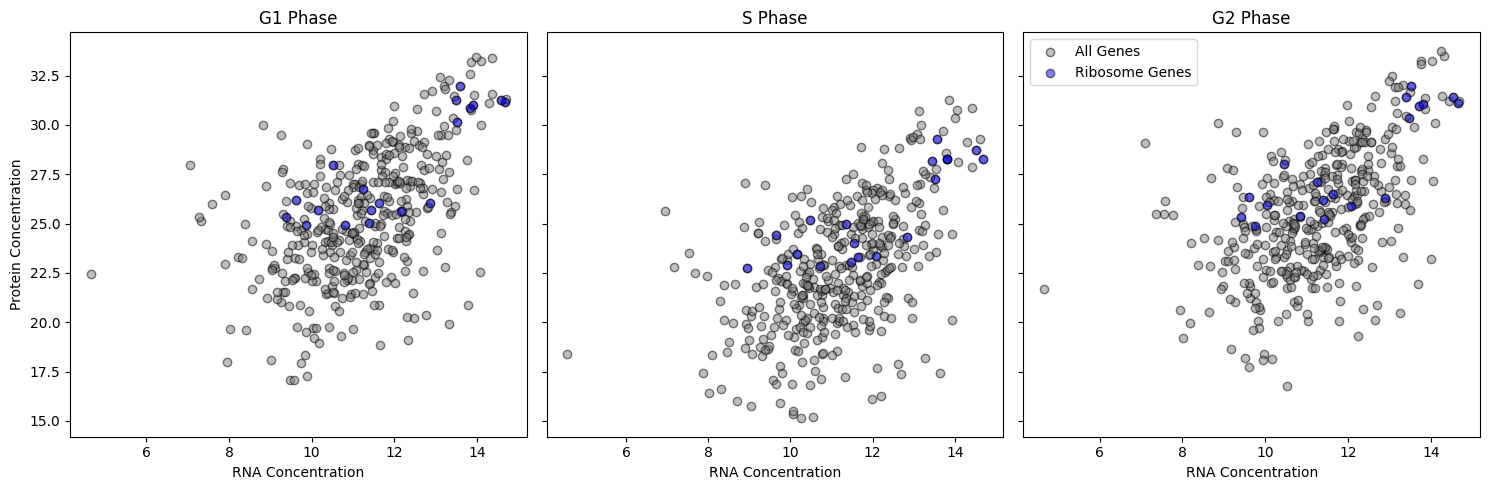

In [107]:
# 1. Find all genes that contain 'ribosome' in their GOCC term:
ribosome_genes = df[df['GOCC'].str.contains('ribosome', case=False)]['Gene_Name']
phases = ['G1', 'S', 'G2']
mRNA_columns = ['mean_RNA_G1', 'mean_RNA_S', 'mean_RNA_G2']
protein_columns = ['mean_protein_G1', 'mean_protein_S', 'mean_protein_G2']



# 2. Plot them as a scatter-plot overlaid across all genes for each stage of the cell cycle:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for i, phase in enumerate(phases):
    axes[i].scatter(df[mRNA_columns[i]], df[protein_columns[i]], label='All Genes', color='gray', alpha=0.5, edgecolors='black')
    axes[i].scatter(df[mRNA_columns[i]][df['Gene_Name'].isin(ribosome_genes)], df[protein_columns[i]][df['Gene_Name'].isin(ribosome_genes)], label='Ribosome Genes', color='blue', alpha=0.5, edgecolors='black')
    axes[i].set_title(f'{phase} Phase')
    axes[i].set_xlabel('RNA Concentration')

axes[0].set_ylabel('Protein Concentration')
plt.legend()
plt.tight_layout()
plt.show()



In [108]:
# 1. Calculate correlations between RNA and protein concentrations for ribosome genes in each stage of the cell cycle and print them:
correlations = {}
correlations_results = []
for stage in ['G1', 'S', 'G2']:
    correlations[stage] = df[df['Gene_Name'].isin(ribosome_genes)][f'mean_RNA_{stage}'].corr(df[df['Gene_Name'].isin(ribosome_genes)][f'mean_protein_{stage}'])
    correlations_results.append({'Stage': stage, 'Correlation': correlations[stage]})

ribosome_df = pd.DataFrame(correlations_results)

# 2. Print the results:
tools.display_dataframe_to_user(name = 'Table 4', dataframe = ribosome_df)


    


Table 4


# Comparing All Genes vs. Ribosome Genes:


+ After separating ribosome genes from all other genes in the dataset, the computed correlation values suggest a strong positive correlation between RNA and protein concentrations for ribosome genes, significantly higher than the moderate correlation observed for all genes.
+ According to the computed scatter-plot, ribosome genes have a much stronger linear relationship between RNA and protein levels than the full dataset of genes.

# Observations - Comment on how these compare, link this to your understanding of the Cell Cycle:


+ Every cell contains the full human genome, but not all genes are expressed in the human body. 
+ Some genes are only expressed at specific developmental stages. 
+ Different cell types express different proteins, thus the concentration of RNA and protein in different genes will vary. 
+ Ribosome genes, which are essential for protein synthesis, are expressed across most cell types. 
+ Cell cycle genes are tightly regulated because their expression is **phase-dependent**. 
+ In each phase, checkpoints are put in place to monitor for errors, before allowing the cell to proceed to the next phase. 
+ If checkpoints detect an error, the cell transits to the Resting phase G0 or undergoes Apoptosis if damage is irreversible. 
+ This regulation leads to fluctuating expression levels of cell cycle genes, thus reducing the consistency of RNA-protein correlation. 
+ On the contrary, ribosome genes as mentioned previously, are expressed across most cell types and remain stably expressed. 
+ Protein synthesis is continuously needed, so ribosome genes do not expreience phase-dependent fluctuations.
+ This stability ensures a strong, stable RNA-protein correlation in ribosome genes, compared to cell cycle genes. 


In [109]:
# 1. Count the number of occurrences of every GOBP term across all genes:
gobp_terms = df['GOBP'].dropna().str.split(';').explode()
cnts = Counter(gobp_terms)

# 2. Convert the results to a DataFrame for better readability (sorting by count):
cnts.columns = ['GOBP Term', 'Count']
cnts = pd.DataFrame(cnts.items(), columns=['GOBP Term', 'Count']).sort_values('Count', ascending=False)

# 3. Display the results:
tools.display_dataframe_to_user(name = 'Table 5', dataframe = cnts)








Table 5


# GOBP Terms Difficulties:


As seen in our dataset, there are a few difficulties arising when using GO terms, specifically GOBP terms:
+ The accuracy of GO functional annotation depends on the quality of the available dataset. In our dataset, some genes (e.g., ESYT2, ZC3H11A) lack corresponding GOBP annotations, which may limit functional insights.
+ GO functional annotation provides detailed descriptions, but its terms vary in specificity. Some are too broad and include many genes, making it hard to extract precise insights, while others are too specific and apply to very few genes, limiting their applicability across different datasets. For example, in our dataset GOBP functions ’cellular process’ and ’metabolic process’ apply to 377 and 273 genes respectively, while GOBP functions such as ’cyanate metabolic process’ and ’cyanate catabolic process’ apply only to 2 genes in the dataset.

Table 6


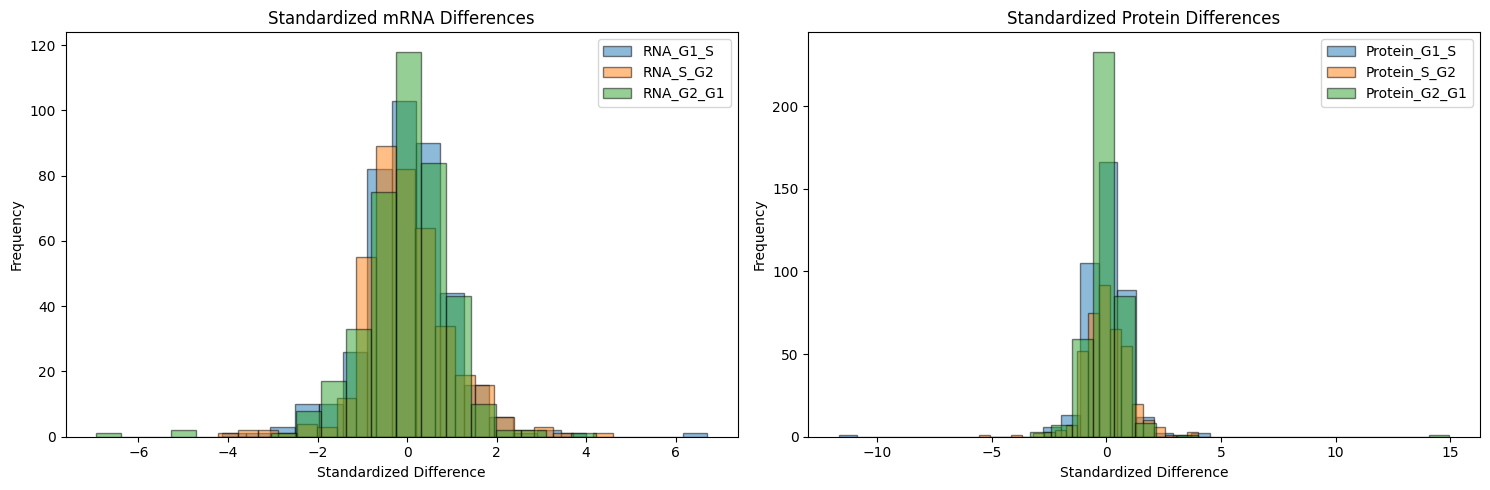

In [110]:
# 1. Calculate the differences:
mRNA_diff_cols = ['RNA_G1_S', 'RNA_S_G2', 'RNA_G2_G1']
protein_diff_cols = ['Protein_G1_S', 'Protein_S_G2', 'Protein_G2_G1']

df[mRNA_diff_cols] = df[['mean_RNA_S', 'mean_RNA_G2', 'mean_RNA_G1']].values - df[['mean_RNA_G1', 'mean_RNA_S', 'mean_RNA_G2']].values
df[protein_diff_cols] = df[['mean_protein_S', 'mean_protein_G2', 'mean_protein_G1']].values - df[['mean_protein_G1', 'mean_protein_S', 'mean_protein_G2']].values



# 2. Standardize the differences by mean centering and variance scaling:
scaler = StandardScaler()
df[mRNA_diff_cols] = scaler.fit_transform(df[mRNA_diff_cols])
df[protein_diff_cols] = scaler.fit_transform(df[protein_diff_cols])


# 3. Print the standardized differences:
standardized_diff_df = df[mRNA_diff_cols + protein_diff_cols]
tools.display_dataframe_to_user(name = 'Table 6', dataframe = standardized_diff_df)

# 4. Plot the standardized differences:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for i, col in enumerate(mRNA_diff_cols):
    axes[0].hist(df[col], bins=20, alpha=0.5, edgecolor='black', label=col)

for i, col in enumerate(protein_diff_cols):
    axes[1].hist(df[col], bins=20, alpha=0.5, edgecolor='black', label=col)

axes[0].set_title('Standardized mRNA Differences')
axes[0].set_xlabel('Standardized Difference')
axes[0].set_ylabel('Frequency')
axes[0].legend()

axes[1].set_title('Standardized Protein Differences')
axes[1].set_xlabel('Standardized Difference')
axes[1].set_ylabel('Frequency')
axes[1].legend()

plt.tight_layout()
plt.show()



# Changes in mRNA/protein levels:


+ The RNA differences across all phases show a **near-normal distribution**, with most values centered around zero, suggesting that RNA levels do not drastically change between cell cycle phases. 
+ The distribution is mostly symmetrical, indicating that RNA expression is tightly regulated across the cell cycle.
+ On the other hand, the protein difference distribution is much **sharper** and **more peaked** around zero, suggesting only a few proteins show large fluctuations across cycle phases.
+ We can also observe that the protein distribution has longer tails as well as that the variance in protein differences appears higher compared to RNA.

# Observations - What do we notice about changes in the cell cycle:


+ RNA expression remains relatively stable across the cell cycle, with only small fluctuations, whereas protein levels show greater variation.
+ This is likely due to the translational and post-translational factors influencing protein expression.
+ These results reinforce the idea that RNA levels cannot be used as the sole predictor for protein levels, as proteins undergo through additional layers of changes.

K: 2, Silhouette Score: 0.2044201251974216
K: 3, Silhouette Score: 0.19091057736988817
K: 4, Silhouette Score: 0.191395219338213
K: 5, Silhouette Score: 0.20052034589139892
K: 6, Silhouette Score: 0.18060684757026854
K: 7, Silhouette Score: 0.17071012251623363
K: 8, Silhouette Score: 0.16462675461464363
K: 9, Silhouette Score: 0.16363626755620927
K: 10, Silhouette Score: 0.15962097002532993


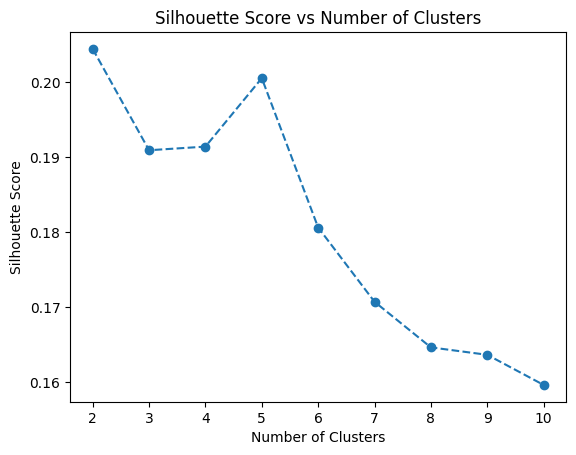

In [111]:
# 1. Use K-means clustering to cluster genes with similar RNA and protein expression levels:
silhouette_scores = []
variables = df[['RNA_G1_S', 'RNA_S_G2', 'RNA_G2_G1', 'Protein_G1_S', 'Protein_S_G2', 'Protein_G2_G1']]

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(variables)
    score = silhouette_score(variables, labels)
    silhouette_scores.append(score)
    print(f'K: {k}, Silhouette Score: {score}')

# 2. Plot silhouette scores to see the optimal number of clusters:
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.show()

    









# Cluster Analysis:

+ To identify optimal clustering of genes based on mRNA and protein expression levels across different cell cycle phases, we applied K-means
clustering to the dataset.
+ The clustering was performed using six features: RNA expression transitions and protein expression transitions. 
+ I evaluated clustering quality using the silhouette score, which measures how well-separated the clusters are. 
+ I iterated over K values from 2 to 10, fitting a K-means model for each and computing the corresponding silhouette score. 
+ The results showed that K=2 had the highest silhouette score initially, but the score peaked at K=5, indicating that five clusters provided the best separation of gene expression patterns. Beyond K=5, the silhouette score declined.

In [112]:
best_k = 5 
kmeans = KMeans(n_clusters=best_k, random_state=42)
df['Cluster'] = kmeans.fit_predict(variables)

In [113]:
# 1. Extract GO terms for each cluster:
go_terms = df[['Cluster', 'GOBP', 'GOMF', 'GOCC']].copy()

# 2. Split GO terms into lists:
for col in ['GOBP', 'GOMF', 'GOCC']:
    go_terms[col] = go_terms[col].str.split(';')  

# 3. Explode each column separately: 
gobp_exploded = go_terms[['Cluster', 'GOBP']].explode('GOBP').dropna()
gomf_exploded = go_terms[['Cluster', 'GOMF']].explode('GOMF').dropna()
gocc_exploded = go_terms[['Cluster', 'GOCC']].explode('GOCC').dropna()

# 4. Rename columns for better readability:
gobp_exploded.rename(columns={'GOBP': 'GO_Term'}, inplace=True)
gomf_exploded.rename(columns={'GOMF': 'GO_Term'}, inplace=True)
gocc_exploded.rename(columns={'GOCC': 'GO_Term'}, inplace=True)

# 5. Concatenate the terms:
go_exploded = pd.concat([gobp_exploded, gomf_exploded, gocc_exploded], axis=0)

# 6. Count occurrences of each GO term per cluster:
go_counts = go_exploded.groupby(['Cluster', 'GO_Term']).size().reset_index(name='Count')

# 7. Convert to DataFrame for better readability:
go_counts_pivot = go_counts.pivot(index='GO_Term', columns='Cluster', values='Count').fillna(0)

# 8. Display the results:
tools.display_dataframe_to_user(name='GO Term Enrichment', dataframe=go_counts_pivot)

# 9. Print the top 5 GO terms per cluster (for analysis):
for cluster in go_counts_pivot.columns:
    print(f"\nTop 5 GO Terms for Cluster {cluster}:")
    print(go_counts_pivot[cluster].sort_values(ascending=False).head(5))






GO Term Enrichment



Top 5 GO Terms for Cluster 0:
GO_Term
cell part             141.0
cellular process      138.0
intracellular part    137.0
binding               133.0
protein binding       101.0
Name: 0, dtype: float64

Top 5 GO Terms for Cluster 1:
GO_Term
cell part             162.0
intracellular part    157.0
cellular process      152.0
binding               146.0
metabolic process     121.0
Name: 1, dtype: float64

Top 5 GO Terms for Cluster 2:
GO_Term
cell part                80.0
cellular process         76.0
binding                  76.0
intracellular part       74.0
biological regulation    63.0
Name: 2, dtype: float64

Top 5 GO Terms for Cluster 3:
GO_Term
membrane-bounded organelle       1.0
Hsp70 protein binding            1.0
adenyl ribonucleotide binding    1.0
protein complex binding          1.0
cellular metabolic process       1.0
Name: 3, dtype: float64

Top 5 GO Terms for Cluster 4:
GO_Term
binding               10.0
cellular process      10.0
cell part              9.0
intracellular

c:\Users\semel\anaconda3\envs\cuda_pytorch_env\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


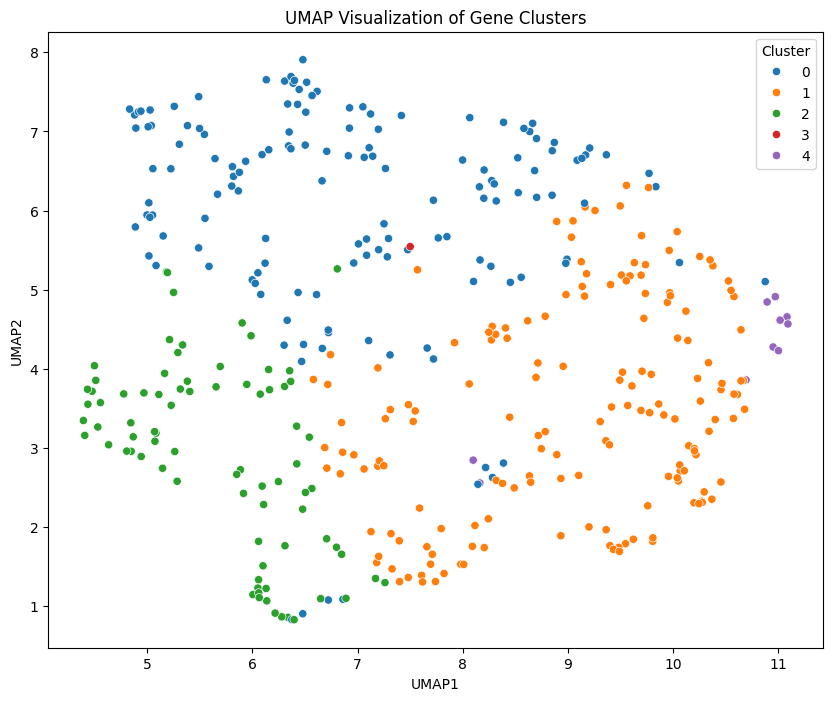

In [114]:

# 1. Visualize the results using UMAP:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(variables)

reducer = umap.UMAP(random_state=42, n_components=2)
embedding = reducer.fit_transform(scaled_data)

df['UMAP1'] = embedding[:, 0]
df['UMAP2'] = embedding[:, 1]

plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x='UMAP1', y='UMAP2', hue='Cluster', palette='tab10', legend='full')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('UMAP Visualization of Gene Clusters')
plt.legend(title='Cluster', loc='upper right')
plt.show()




# GO Enrichment Analysis: 
After forming the clusters, I analyzed the GO terms for each cluster. The results indicate the following:

+ Cluster 0: This cluster is highly enriched in cell part (GO : 0033643), cellular processes (GO : 0009987), binding (GO : 0005488) and protein
binding (GO : 0005515). This cluster likely contains structural and regulatory genes involved in cellular organization as well as molecular func-
tions.
+ Cluster 1: This cluster is highly enriched in cell part (GO : 0033643), intracellular part (GO : 0033646), metabolic processes (GO : 0008152)
and binding (GO : 0005488). This suggests that this cluster involves genes involved in cell metabolism, as well as chemical pathways.
+ Cluster 2: This cluster is highly enriched in cell part (GO : 0033643), binding (GO : 0005488), intracellular part (GO : 0033646) and biological regulation (GO : 0065007).
+ Cluster 3: This cluster is slightly enriched in terms, including membrane-bounded organelle (GO : 0043227), Hsp70 protein binding (GO : 0030544), adenyl ribonucleotide binding (GO : 0032559) etc. This cluster may contain specialized or misclassified genes, potentially involved in stress responses (Hsp70 binding) or nucleotide metabolism.
+ Cluster 4: This cluster is highly enriched in binding (GO : 0005488), cellular processes (GO : 0009987) and protein binding (GO : 0005515). Similarly to Cluster 0, this cluster is likely enriched in genes encoding proteins, or genes involved in molecular functions.

# Further Observations: 

+ Visualizing the gene clusters using dimensionality reduction technique UMAP 7, it is revealed that Clusters 0,1 and 2 are well-separated, sug-
gesting genes with distinct expression patterns, likely involved in different cellular processes. 
+ Clusters 0 and 1 show slight overlap, indicating functional similarity between the genes in the two clusters. 
+ Cluster 3 is small and isolated, potentially representing specialized or outlier genes, while Cluster 4 is compact, suggesting
genes with highly similar expression profiles.